# 02. Cross-Validation for Model Evaluation | التحقق المتقاطع لتقييم النماذج

## 📚 Prerequisites (What You Need First) | المتطلبات الأساسية

**BEFORE starting this notebook**, you should have completed:
- ✅ **Unit 1: All examples** - Data processing and basic regression
- ✅ **Unit 2, Example 1: Ridge and Lasso** - Understanding model evaluation
- ✅ **Understanding of train-test split**: Why we split data

**If you haven't completed these**, you might struggle with:
- Understanding why cross-validation is better than simple train-test split
- Knowing when to use K-Fold vs Leave-One-Out
- Understanding how cross-validation helps with model selection

---

## 🔗 Where This Notebook Fits | مكان هذا الدفتر

**This is Unit 2, Example 2** - it improves how we evaluate models!

**Why this example SECOND in Unit 2?**
- **Before** you can properly evaluate models, you need to understand basic evaluation
- **Before** you can select the best model, you need reliable evaluation methods
- **Before** you can tune hyperparameters, you need cross-validation

**Builds on**: 
- 📓 Unit 1, Example 3: Train-Test Split (we know basic splitting)
- 📓 Unit 2, Example 1: Ridge/Lasso (we evaluated models with simple split)

**Leads to**: 
- 📓 Unit 5, Example 1: Grid Search (uses cross-validation for hyperparameter tuning)
- 📓 All ML projects (cross-validation is the gold standard for evaluation!)

**Why this order?**
1. Cross-validation improves **model evaluation** (more reliable than single split)
2. Cross-validation enables **model comparison** (fair comparison between models)
3. Cross-validation is essential for **hyperparameter tuning** (used in grid search)

---

## The Story: Getting Multiple Opinions | القصة: الحصول على آراء متعددة

Imagine you're hiring someone. **Before** cross-validation, you ask one person's opinion (single train-test split) - might be biased! **After** cross-validation, you ask multiple people (multiple folds) and average their opinions - much more reliable!

Same with machine learning: **Before** cross-validation, we evaluate on one test set (might be lucky/unlucky). **After** cross-validation, we evaluate on multiple test sets and average - much more reliable!

---

## Why Cross-Validation Matters | لماذا يهم التحقق المتقاطع؟

Cross-validation is the gold standard for model evaluation:
- **More Reliable**: Uses all data for both training and testing (in different folds)
- **Less Variance**: Averages results across multiple folds
- **Better Model Selection**: Fairly compares different models
- **Detects Overfitting**: Shows if model performance varies across folds
- **Industry Standard**: Used in all professional ML projects

## Learning Objectives | أهداف التعلم
1. Implement K-Fold Cross-Validation
2. Use cross-validation for model comparison
3. Understand Leave-One-Out Cross-Validation (LOOCV)
4. Compare models using cross-validation scores
5. Visualize cross-validation splits and results
6. Know when to use each cross-validation method

In [1]:
# Step 1: Import necessary libraries
# These libraries help us perform cross-validation

import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For visualizations
from sklearn.model_selection import (
    KFold,              # K-Fold cross-validation (splits data into K folds)
    StratifiedKFold,    # Stratified K-Fold (maintains class distribution)
    LeaveOneOut,        # Leave-One-Out CV (each sample is a fold)
    cross_val_score,    # Computes cross-validation scores
    cross_validate,     # Computes multiple metrics with CV
    train_test_split    # Simple train-test split (for comparison)
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # Models to evaluate
from sklearn.preprocessing import StandardScaler  # For scaling features
from sklearn.metrics import mean_squared_error, r2_score, make_scorer  # Evaluation metrics

print("✅ Libraries imported successfully!")
print("\n📚 What each cross-validation tool does:")
print("   - KFold: Splits data into K equal folds")
print("   - cross_val_score: Computes scores for each fold")
print("   - cross_validate: Computes multiple metrics at once")
print("   - LeaveOneOut: Each sample is its own test set (expensive but thorough)")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


✅ Libraries imported successfully!

📚 What each cross-validation tool does:
   - KFold: Splits data into K equal folds
   - cross_val_score: Computes scores for each fold
   - cross_validate: Computes multiple metrics at once
   - LeaveOneOut: Each sample is its own test set (expensive but thorough)


## Part 1: Setting the Scene | الجزء الأول: إعداد المشهد

**BEFORE**: We've been using simple train-test split, but this only uses data once and might give unreliable results.

**AFTER**: We'll use cross-validation - splitting data multiple times and averaging results for more reliable evaluation!

**Why this matters**: Single train-test split can be lucky or unlucky. Cross-validation gives you multiple evaluations and averages them - much more reliable!

In [2]:
# Generate sample data for cross-validation demonstration
# We'll use this to compare simple train-test split vs cross-validation

print("\n1. Generating sample data...")
print("إنشاء بيانات نموذجية...")

np.random.seed(42)  # For reproducibility
n_samples = 200
X = np.random.randn(n_samples, 5)  # 5 features
# Target depends on first 4 features (feature_4 is noise)
y = (2 * X[:, 0] + 1.5 * X[:, 1] - X[:, 2] +
     3 * X[:, 3] + np.random.normal(0, 0.5, n_samples))

df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(5)])
df['target'] = y

print(f"\n📊 Data Shape: {df.shape}")
print(df.head())
print("\n🔍 Notice:")
print("   - 200 samples with 5 features")
print("   - Target depends on features 0-3 (feature_4 is noise)")
print("   - We'll use this to compare evaluation methods!")



1. Generating sample data...
إنشاء بيانات نموذجية...

📊 Data Shape: (200, 6)
   feature_0  feature_1  feature_2  feature_3  feature_4    target
0   0.496714  -0.138264   0.647689   1.523030  -0.234153  5.407111
1  -0.234137   1.579213   0.767435  -0.469474   0.542560  0.187004
2  -0.463418  -0.465730   0.241962  -1.913280  -1.724918 -7.577418
3  -0.562288  -1.012831   0.314247  -0.908024  -1.412304 -6.005610
4   1.465649  -0.225776   0.067528  -1.424748  -0.544383 -1.400028

🔍 Notice:
   - 200 samples with 5 features
   - Target depends on features 0-3 (feature_4 is noise)
   - We'll use this to compare evaluation methods!


## Step 1: Generate Sample Data | الخطوة 1: إنشاء بيانات نموذجية

**BEFORE**: We need to learn cross-validation, but we need sample data to practice on.

**AFTER**: We'll create data to demonstrate different cross-validation methods!

**Why create this data?** We need data to compare simple split vs cross-validation!

In [3]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
print("\n" + "=" * 60)
print("1. Simple Train-Test Split (Baseline)")
print("التقسيم البسيط تدريب-اختبار (خط الأساس)")
print("=" * 60)

# Simple train-test split (what we've been using)
# Why show this? To compare with cross-validation!
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model_simple = LinearRegression()
model_simple.fit(X_train, y_train)
y_pred = model_simple.predict(X_test)

mse_simple = mean_squared_error(y_test, y_pred)
r2_simple = r2_score(y_test, y_pred)

print(f"\n📊 Simple Train-Test Split Results:")
print(f"   Test MSE: {mse_simple:.4f}")
print(f"   Test R²: {r2_simple:.4f}")
print(f"\n   ⚠️  Problem: This is just ONE evaluation!")
print(f"   - If we're lucky with this split, score looks good")
print(f"   - If we're unlucky, score looks bad")
print(f"   - Cross-validation will give us multiple evaluations!")



1. Simple Train-Test Split (Baseline)
التقسيم البسيط تدريب-اختبار (خط الأساس)

📊 Simple Train-Test Split Results:
   Test MSE: 0.2295
   Test R²: 0.9864

   ⚠️  Problem: This is just ONE evaluation!
   - If we're lucky with this split, score looks good
   - If we're unlucky, score looks bad
   - Cross-validation will give us multiple evaluations!


## Step 2: Simple Train-Test Split (Baseline) | الخطوة 2: التقسيم البسيط (خط الأساس)

**BEFORE**: We've been using simple train-test split. Let's see its limitations.

**AFTER**: We'll see that single split gives one score, but cross-validation gives multiple scores and an average!

**Why start with simple split?** It's what we know. We'll compare it to cross-validation to see the improvement!

In [5]:
print("\n" + "=" * 60)
print("2. K-Fold Cross-Validation")
print("التحقق المتقاطع K-Fold")
print("=" * 60)

# Create K-Fold cross-validator
# n_splits=5 means we split data into 5 folds
# shuffle=True randomizes the order (better for evaluation)
# random_state=42 for reproducibility
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
model_kfold = LinearRegression()

print("\n   ✅ K-Fold CV created (5 folds)")
print("   How it works:")
print("   - Split data into 5 equal parts (folds)")
print("   - Use fold 1 as test, folds 2-5 as train → score 1")
print("   - Use fold 2 as test, folds 1,3-5 as train → score 2")
print("   - ... repeat for all 5 folds")
print("   - Average all 5 scores → final reliable score!")



2. K-Fold Cross-Validation
التحقق المتقاطع K-Fold

   ✅ K-Fold CV created (5 folds)
   How it works:
   - Split data into 5 equal parts (folds)
   - Use fold 1 as test, folds 2-5 as train → score 1
   - Use fold 2 as test, folds 1,3-5 as train → score 2
   - ... repeat for all 5 folds
   - Average all 5 scores → final reliable score!


## Step 3: K-Fold Cross-Validation | الخطوة 3: التحقق المتقاطع K-Fold

**BEFORE**: Simple split gives one evaluation that might be lucky or unlucky.

**AFTER**: K-Fold CV splits data into K folds, trains K times, and averages results - much more reliable!

**Why K-Fold?**
- **Splits data into K folds**: Each fold becomes test set once
- **Trains K times**: Uses all data for both training and testing
- **Averages results**: More reliable than single evaluation
- **Standard choice**: K=5 or K=10 are most common

In [6]:
# Perform cross-validation
# cross_val_score automatically:
# 1. Splits data using kfold
# 2. Trains model on each training fold
# 3. Evaluates on each test fold
# 4. Returns scores for all folds

cv_scores_mse = cross_val_score(model_kfold, X_scaled, y,
                                cv=kfold, scoring='neg_mean_squared_error')
# Note: 'neg_mean_squared_error' returns negative MSE (sklearn convention)
# We'll convert to positive when displaying

cv_scores_r2 = cross_val_score(model_kfold, X_scaled, y,
                               cv=kfold, scoring='r2')

print(f"\n📊 5-Fold Cross-Validation Results:")
print(f"نتائج التحقق المتقاطع 5-Fold:")

print("\n📈 MSE Scores (for each fold):")
for i, score in enumerate(cv_scores_mse):
    print(f"   Fold {i+1}: {-score:.4f}")

print("\n📈 R² Scores (for each fold):")
for i, score in enumerate(cv_scores_r2):
    print(f"   Fold {i+1}: {score:.4f}")

# Calculate mean and standard deviation
# Mean = average performance across all folds
# Std = how much performance varies (lower is better - more stable!)
mean_mse = -cv_scores_mse.mean()
std_mse = cv_scores_mse.std()
mean_r2 = cv_scores_r2.mean()
std_r2 = cv_scores_r2.std()

print(f"\n✅ Summary Statistics:")
print(f"   Mean MSE: {mean_mse:.4f} (+/- {std_mse * 2:.4f})")
print(f"   Mean R²: {mean_r2:.4f} (+/- {std_r2 * 2:.4f})")
print(f"\n   📊 Comparison with Simple Split:")
print(f"   - Simple Split R²: {r2_simple:.4f}")
print(f"   - CV Mean R²: {mean_r2:.4f}")
print(f"   - CV gives us confidence interval: {mean_r2 - std_r2*2:.4f} to {mean_r2 + std_r2*2:.4f}")
print(f"   - Much more informative than single score!")


📊 5-Fold Cross-Validation Results:
نتائج التحقق المتقاطع 5-Fold:

📈 MSE Scores (for each fold):
   Fold 1: 0.2295
   Fold 2: 0.2277
   Fold 3: 0.3326
   Fold 4: 0.2307
   Fold 5: 0.3252

📈 R² Scores (for each fold):
   Fold 1: 0.9864
   Fold 2: 0.9796
   Fold 3: 0.9796
   Fold 4: 0.9842
   Fold 5: 0.9697

✅ Summary Statistics:
   Mean MSE: 0.2691 (+/- 0.0977)
   Mean R²: 0.9799 (+/- 0.0115)

   📊 Comparison with Simple Split:
   - Simple Split R²: 0.9864
   - CV Mean R²: 0.9799
   - CV gives us confidence interval: 0.9684 to 0.9914
   - Much more informative than single score!


In [7]:
# 3. Cross-Validate with Multiple Metrics
print("\n" + "=" * 60)
print("3. Cross-Validate with Multiple Metrics")
print("التحقق المتقاطع بمقاييس متعددة")
print("=" * 60)
scoring = {
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}
cv_results = cross_validate(model_kfold, X_scaled, y,
                           cv=kfold, scoring=scoring, return_train_score=True)
print("\nCross-Validation Results (Multiple Metrics):")
print("نتائج التحقق المتقاطع (مقاييس متعددة):")
print(f"\nTest MSE: {-cv_results['test_mse'].mean():.4f} (+/- {cv_results['test_mse'].std() * 2:.4f})")
print(f"Test MAE: {-cv_results['test_mae'].mean():.4f} (+/- {cv_results['test_mae'].std() * 2:.4f})")
print(f"Test R²: {cv_results['test_r2'].mean():.4f} (+/- {cv_results['test_r2'].std() * 2:.4f})")


3. Cross-Validate with Multiple Metrics
التحقق المتقاطع بمقاييس متعددة

Cross-Validation Results (Multiple Metrics):
نتائج التحقق المتقاطع (مقاييس متعددة):

Test MSE: 0.2691 (+/- 0.0977)
Test MAE: 0.4123 (+/- 0.0652)
Test R²: 0.9799 (+/- 0.0115)


In [ ]:
# 4. Comparing Different Models with Cross-Validation
print("\n" + "=" * 60)
print("4. Comparing Different Models with Cross-Validation")
print("مقارنة نماذج مختلفة باستخدام التحقق المتقاطع")
print("=" * 60)
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1)': Ridge(alpha=1.0),
    'Ridge (α=10)': Ridge(alpha=10.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1),
    'Lasso (α=1)': Lasso(alpha=1.0)
}
results = []
for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y,
                                cv=kfold, scoring='neg_mean_squared_error')
    results.append({
        'Model': name,
        'Mean MSE': -cv_scores.mean(),
        'Std MSE': cv_scores.std(),
        'Mean R²': cross_val_score(model, X_scaled, y, cv=kfold, scoring='r2').mean()
    })
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.to_string(index=False))

# Add interpretation
print("\n" + "=" * 60)
print("💡 Interpreting Cross-Validation Results | تفسير نتائج التحقق المتقاطع")
print("=" * 60)

best_mse_idx = results_df['Mean MSE'].idxmin()
best_r2_idx = results_df['Mean R²'].idxmax()
best_model_mse = results_df.loc[best_mse_idx, 'Model']
best_model_r2 = results_df.loc[best_r2_idx, 'Model']

print(f"\n📊 Best Model by MSE: {best_model_mse}")
print(f"   - Mean MSE: {results_df.loc[best_mse_idx, 'Mean MSE']:.4f}")
print(f"   - Std MSE: {results_df.loc[best_mse_idx, 'Std MSE']:.4f}")
print(f"   - Lower MSE = better predictions")

print(f"\n📊 Best Model by R²: {best_model_r2}")
print(f"   - Mean R²: {results_df.loc[best_r2_idx, 'Mean R²']:.4f}")
print(f"   - Higher R² = explains more variance")

print(f"\n🔍 Understanding Standard Deviation:")
print(f"   - Std MSE shows variability across folds")
print(f"   - Lower std = more consistent performance")
print(f"   - High std = model performance varies a lot")

for idx, row in results_df.iterrows():
    std_ratio = row['Std MSE'] / row['Mean MSE']
    if std_ratio < 0.1:
        consistency = "✅ Very consistent"
    elif std_ratio < 0.2:
        consistency = "✅ Consistent"
    else:
        consistency = "⚠️  Variable"
    print(f"   - {row['Model']}: Std/MSE ratio = {std_ratio:.2f} ({consistency})")

print(f"\n📊 Regularization Analysis:")
ridge_models = results_df[results_df['Model'].str.contains('Ridge')]
lasso_models = results_df[results_df['Model'].str.contains('Lasso')]

if len(ridge_models) > 0:
    best_ridge = ridge_models.loc[ridge_models['Mean MSE'].idxmin()]
    print(f"   - Best Ridge: {best_ridge['Model']} (MSE: {best_ridge['Mean MSE']:.4f})")
    print(f"   - Alpha = 1.0 vs 10.0: {'Lower alpha is better' if best_ridge['Model'].endswith('1)') else 'Higher alpha is better'}")

if len(lasso_models) > 0:
    best_lasso = lasso_models.loc[lasso_models['Mean MSE'].idxmin()]
    print(f"   - Best Lasso: {best_lasso['Model']} (MSE: {best_lasso['Mean MSE']:.4f})")
    print(f"   - Alpha = 0.1 vs 1.0: {'Lower alpha is better' if best_lasso['Model'].endswith('0.1)') else 'Higher alpha is better'}")

print(f"\n📚 What This Teaches Us:")
print(f"   - Cross-validation gives reliable model comparison")
print(f"   - Mean shows average performance, Std shows consistency")
print(f"   - Lower std = more reliable model")
print(f"   - Compare models using both mean and std")
print(f"   - Regularization (Ridge/Lasso) may or may not improve performance")
print(f"   - Alpha (regularization strength) needs tuning - not always better")
print(f"   - CV prevents overfitting to a single train/test split")


4. Comparing Different Models with Cross-Validation
مقارنة نماذج مختلفة باستخدام التحقق المتقاطع

Model Comparison:
            Model  Mean MSE  Std MSE  Mean R²
Linear Regression  0.269142 0.048865 0.979902
      Ridge (α=1)  0.269489 0.048293 0.979906
     Ridge (α=10)  0.327250 0.052441 0.976006
    Lasso (α=0.1)  0.315092 0.048795 0.976819
      Lasso (α=1)  4.646945 0.675551 0.662047


In [9]:
# Find best model
best_model_name = results_df.loc[results_df['Mean MSE'].idxmin(), 'Model']
print(f"\nBest Model (lowest MSE): {best_model_name}")


Best Model (lowest MSE): Linear Regression


In [10]:
# 5. K-Fold Visualization
print("\n" + "=" * 60)
print("5. K-Fold Visualization")
print("تصور K-Fold")
print("=" * 60)


5. K-Fold Visualization
تصور K-Fold



✓ Plot saved as 'kfold_visualization.png'


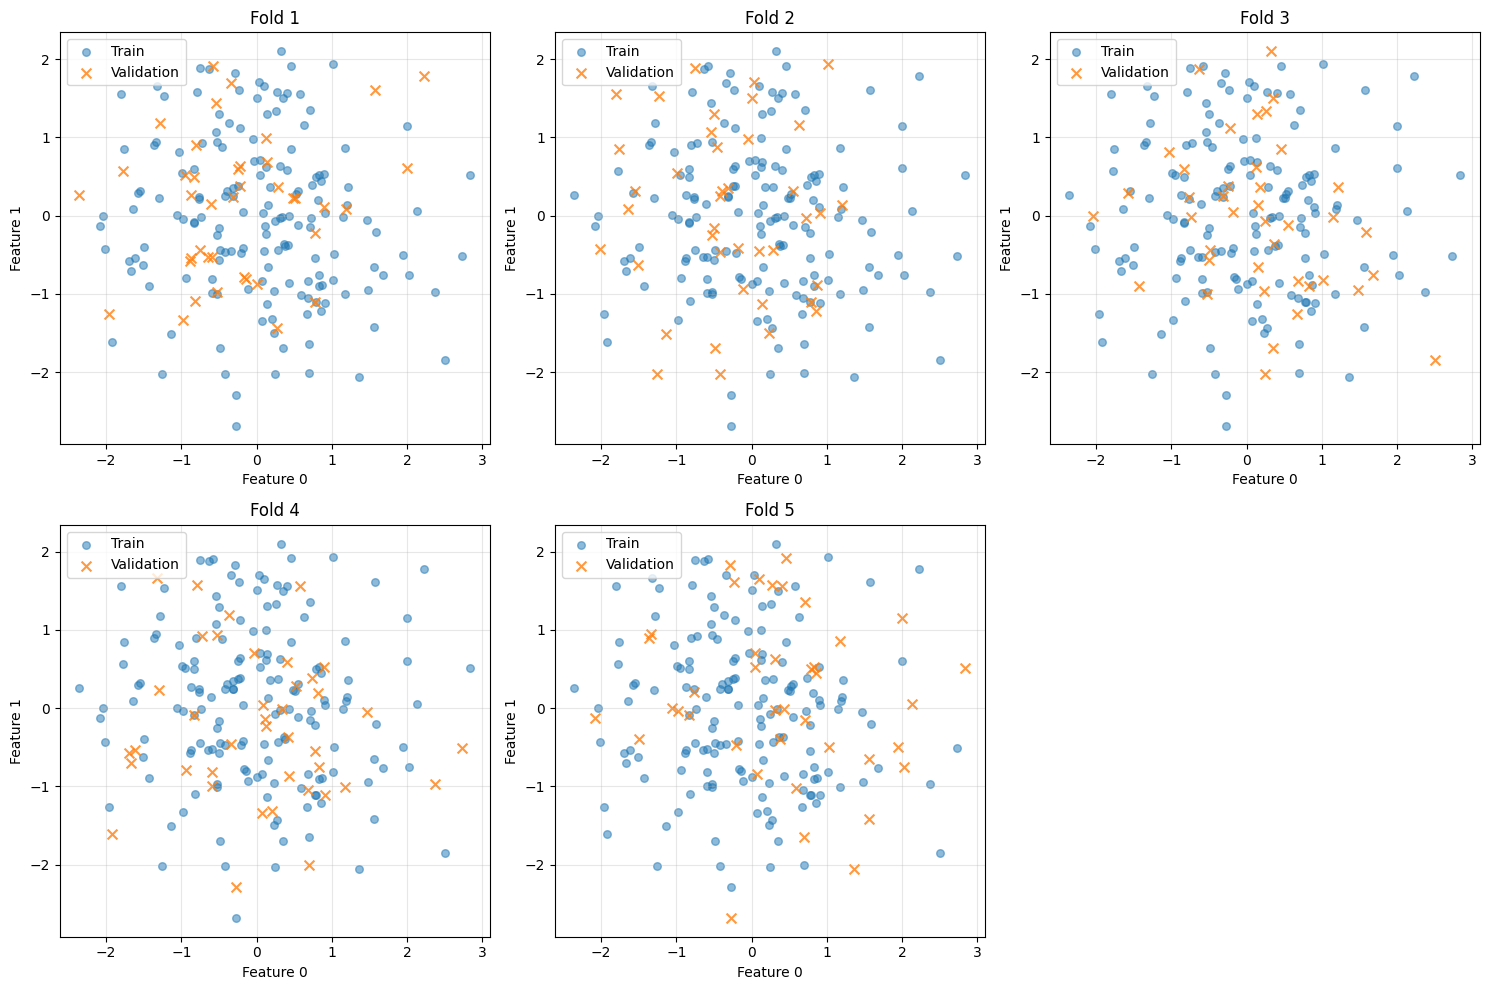

In [11]:
# Visualize K-Fold splits
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

kfold_viz = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, val_idx) in enumerate(kfold_viz.split(X_scaled)):
    ax = axes[fold_idx]
    
    # Plot training data
    ax.scatter(X_scaled[train_idx, 0], X_scaled[train_idx, 1],
              alpha=0.5, label='Train', s=30)
    
    # Plot validation data
    ax.scatter(X_scaled[val_idx, 0], X_scaled[val_idx, 1],
              alpha=0.8, label='Validation', s=50, marker='x')
    
    ax.set_title(f'Fold {fold_idx + 1}')
    ax.set_xlabel('Feature 0')
    ax.set_ylabel('Feature 1')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.savefig('kfold_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Plot saved as 'kfold_visualization.png'")
plt.show()

In [12]:
# 6. Leave-One-Out Cross-Validation (LOOCV)
print("\n" + "=" * 60)
print("6. Leave-One-Out Cross-Validation (LOOCV)")
print("التحقق المتقاطع بإخراج واحد (LOOCV)")
print("=" * 60)
print("\nNote: LOOCV is computationally expensive for large datasets")
print("ملاحظة: LOOCV مكلف حسابياً لمجموعات البيانات الكبيرة")


6. Leave-One-Out Cross-Validation (LOOCV)
التحقق المتقاطع بإخراج واحد (LOOCV)

Note: LOOCV is computationally expensive for large datasets
ملاحظة: LOOCV مكلف حسابياً لمجموعات البيانات الكبيرة


In [13]:
# Use smaller sample for demonstration
X_small = X_scaled[:50]
y_small = y[:50]
loocv = LeaveOneOut()
loocv_scores = cross_val_score(LinearRegression(), X_small, y_small,
                               cv=loocv, scoring='r2')
print(f"\nLOOCV Results (n={len(y_small)}):")
print(f"Mean R²: {loocv_scores.mean():.4f}")
print(f"Std R²: {loocv_scores.std():.4f}")
print(f"Min R²: {loocv_scores.min():.4f}")
print(f"Max R²: {loocv_scores.max():.4f}")


LOOCV Results (n=50):
Mean R²: nan
Std R²: nan
Min R²: nan
Max R²: nan


/opt/anaconda3/envs/course2/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/course2/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/course2/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/course2/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/course2/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 scor

In [14]:
# 7. Cross-Validation Score Distribution
print("\n" + "=" * 60)
print("7. Cross-Validation Score Distribution")
print("توزيع نتائج التحقق المتقاطع")
print("=" * 60)


7. Cross-Validation Score Distribution
توزيع نتائج التحقق المتقاطع


In [15]:
# Get scores for all folds
all_scores = []
for train_idx, val_idx in kfold.split(X_scaled):
    model_temp = LinearRegression()
    model_temp.fit(X_scaled[train_idx], y[train_idx])
    pred = model_temp.predict(X_scaled[val_idx])
    score = r2_score(y[val_idx], pred)
    all_scores.append(score)

## Step 8: Decision Framework - When to Use Each Cross-Validation Method | الخطوة 8: إطار القرار - متى تستخدم كل طريقة تحقق متقاطع

**BEFORE**: You've learned different cross-validation methods, but when should you use each one?

**AFTER**: You'll have a clear decision framework to choose the right cross-validation method for any situation!

**Why this matters**: Using the wrong cross-validation method can:
- **Unreliable evaluation** → Wrong method gives biased estimates
- **Wasted computation** → Using expensive methods when simple ones work
- **Poor model selection** → Wrong evaluation leads to wrong model choice

---

### 🎯 Decision Framework: Which Cross-Validation Method? | إطار القرار: أي طريقة تحقق متقاطع؟

**Key Question**: Should I use **K-FOLD**, **STRATIFIED K-FOLD**, **LEAVE-ONE-OUT**, or **SIMPLE TRAIN-TEST SPLIT**?

#### Decision Tree:

```
What type of problem do you have?
├─ CLASSIFICATION → Check class balance
│   ├─ Balanced classes → Use STRATIFIED K-FOLD ✅
│   │   └─ Why? Maintains class distribution in each fold
│   │
│   └─ Imbalanced classes → Use STRATIFIED K-FOLD ✅
│       └─ Why? Critical for imbalanced data
│
└─ REGRESSION → Check dataset size
    ├─ Small dataset (< 100 samples) → Use LEAVE-ONE-OUT ✅
    │   └─ Why? Maximum data usage, most reliable
    │
    ├─ Medium dataset (100-10,000) → Use K-FOLD (K=5 or 10) ✅
    │   └─ Why? Good balance of reliability and speed
    │
    └─ Large dataset (> 10,000) → Use SIMPLE TRAIN-TEST SPLIT or K-FOLD (K=5) ✅
        └─ Why? Large datasets, simple split is often sufficient
```

#### Detailed Decision Process:

```
Step 1: Problem Type
├─ Classification → Go to Step 2
└─ Regression → Go to Step 3

Step 2: Classification - Check Class Balance
├─ Balanced classes (similar counts) → Use STRATIFIED K-FOLD (K=5 or 10)
│   └─ Why? Maintains class distribution
│
└─ Imbalanced classes (very different counts) → Use STRATIFIED K-FOLD (K=5 or 10)
    └─ Why? Critical to maintain distribution in imbalanced data

Step 3: Regression - Check Dataset Size
├─ Very small (< 50 samples) → Use LEAVE-ONE-OUT (LOOCV)
│   └─ Why? Maximum data usage, most reliable for small data
│
├─ Small (50-100 samples) → Use K-FOLD (K=10) or LEAVE-ONE-OUT
│   └─ Why? Need more folds for reliable estimate
│
├─ Medium (100-10,000 samples) → Use K-FOLD (K=5 or 10)
│   └─ Why? Standard choice, good balance
│
└─ Large (> 10,000 samples) → Use SIMPLE TRAIN-TEST SPLIT or K-FOLD (K=5)
    └─ Why? Large datasets, simple split often sufficient
```

---

### 📊 Comparison Table: Cross-Validation Methods | جدول المقارنة

| Method | When to Use | Pros | Cons | Example |
|--------|-------------|------|------|---------|
| **Simple Train-Test Split** | Large datasets, quick evaluation | • Fast<br>• Simple<br>• One evaluation | • Less reliable<br>• Single split may be lucky/unlucky<br>• Doesn't use all data | Dataset with 50,000+ samples |
| **K-Fold (K=5)** | Medium datasets, standard choice | • Reliable<br>• Uses all data<br>• Good balance | • 5 evaluations (slower)<br>• May not maintain class distribution | Dataset with 1,000-10,000 samples |
| **K-Fold (K=10)** | Small-medium datasets, more reliable | • Very reliable<br>• Uses all data<br>• More folds = better estimate | • 10 evaluations (slower)<br>• More computation | Dataset with 100-5,000 samples |
| **Stratified K-Fold** | Classification problems (any size) | • Maintains class distribution<br>• Reliable for classification<br>• Works with imbalanced data | • Only for classification<br>• Slightly more complex | Any classification problem |
| **Leave-One-Out (LOOCV)** | Very small datasets | • Maximum data usage<br>• Most reliable for small data<br>• Unbiased estimate | • Very slow (n evaluations)<br>• High variance<br>• Expensive | Dataset with < 50 samples |

---

### ✅ When to Use Each Method | متى تستخدم كل طريقة

#### Use Simple Train-Test Split when:
1. **Large Dataset** ✅
   - More than 10,000 samples
   - Single split is reliable enough
   - **Example**: 50,000+ samples, quick evaluation needed

2. **Quick Evaluation** ✅
   - Need fast results
   - Don't need maximum reliability
   - **Example**: Initial model testing, baseline evaluation

3. **Computational Constraints** ✅
   - Very expensive models (deep learning)
   - Can't afford multiple evaluations
   - **Example**: Training neural networks

#### Use K-Fold (K=5) when:
1. **Medium Dataset** ✅
   - 1,000-10,000 samples
   - Standard choice for most problems
   - **Example**: Most regression problems

2. **Balanced Reliability/Speed** ✅
   - Need reliable evaluation
   - Don't want too slow
   - **Example**: Model comparison, hyperparameter tuning

#### Use K-Fold (K=10) when:
1. **Small-Medium Dataset** ✅
   - 100-5,000 samples
   - Need more reliable estimate
   - **Example**: Limited data, need best estimate

2. **Model Selection** ✅
   - Comparing multiple models
   - Need reliable comparison
   - **Example**: Choosing between different algorithms

#### Use Stratified K-Fold when:
1. **Classification Problem** ✅
   - Any classification task
   - Maintains class distribution
   - **Example**: Binary or multiclass classification

2. **Imbalanced Classes** ✅
   - Classes have very different counts
   - Critical to maintain distribution
   - **Example**: Fraud detection (99% normal, 1% fraud)

3. **Small Classification Dataset** ✅
   - Small dataset with classes
   - Need to maintain distribution
   - **Example**: Medical diagnosis with limited data

#### Use Leave-One-Out (LOOCV) when:
1. **Very Small Dataset** ✅
   - Less than 50 samples
   - Need maximum data usage
   - **Example**: Rare disease study with 30 patients

2. **Maximum Reliability Needed** ✅
   - Small dataset, need best estimate
   - Can afford computation time
   - **Example**: Expensive data collection, need best evaluation

---

### ❌ When NOT to Use Each Method | متى لا تستخدم كل طريقة

#### Don't use Simple Train-Test Split when:
1. **Small Dataset** ❌
   - Less than 1,000 samples
   - Single split unreliable
   - **Use Instead**: K-Fold or LOOCV

2. **Model Selection** ❌
   - Comparing multiple models
   - Need reliable comparison
   - **Use Instead**: K-Fold Cross-Validation

#### Don't use K-Fold when:
1. **Very Small Dataset** ❌
   - Less than 50 samples
   - K folds may have too few samples per fold
   - **Use Instead**: Leave-One-Out (LOOCV)

2. **Imbalanced Classification** ❌
   - Classes very imbalanced
   - K-Fold may not maintain distribution
   - **Use Instead**: Stratified K-Fold

#### Don't use Stratified K-Fold when:
1. **Regression Problem** ❌
   - Predicting continuous values
   - No classes to stratify
   - **Use Instead**: Regular K-Fold

#### Don't use Leave-One-Out when:
1. **Large Dataset** ❌
   - More than 100 samples
   - Too slow, high variance
   - **Use Instead**: K-Fold (K=5 or 10)

2. **Computational Constraints** ❌
   - Expensive models
   - Can't afford n evaluations
   - **Use Instead**: K-Fold (K=5)

---

### 📊 Real-World Examples | أمثلة من العالم الحقيقي

#### Example 1: House Price Prediction (5,000 samples) ✅ K-FOLD (K=5)
- **Problem**: Regression (predicting price)
- **Dataset Size**: 5,000 samples (medium)
- **Decision**: ✅ Use K-Fold (K=5)
- **Reasoning**: Medium dataset, regression problem, standard choice

#### Example 2: Customer Churn Prediction (10,000 samples, imbalanced) ✅ STRATIFIED K-FOLD
- **Problem**: Classification (churn/not churn)
- **Dataset Size**: 10,000 samples
- **Class Balance**: Imbalanced (95% not churn, 5% churn)
- **Decision**: ✅ Use Stratified K-Fold (K=5)
- **Reasoning**: Classification, imbalanced classes, need to maintain distribution

#### Example 3: Rare Disease Diagnosis (30 samples) ✅ LEAVE-ONE-OUT
- **Problem**: Classification (disease/healthy)
- **Dataset Size**: 30 samples (very small)
- **Decision**: ✅ Use Leave-One-Out (LOOCV)
- **Reasoning**: Very small dataset, need maximum data usage, can afford computation

#### Example 4: Image Classification (100,000 samples) ✅ SIMPLE SPLIT or K-FOLD (K=5)
- **Problem**: Classification (10 classes)
- **Dataset Size**: 100,000 samples (large)
- **Decision**: ✅ Use Simple Train-Test Split or K-Fold (K=5)
- **Reasoning**: Large dataset, simple split often sufficient, or K=5 for more reliability

---

### ✅ Key Takeaways | النقاط الرئيسية

1. **Classification → Stratified K-Fold** - Always use stratified for classification
2. **Small data → More folds** - Use K=10 or LOOCV for small datasets
3. **Large data → Simple split** - Simple split often sufficient for large datasets
4. **Standard choice → K=5** - Good default for most problems
5. **Imbalanced → Stratified** - Critical for imbalanced classification
6. **Model selection → K-Fold** - Use K-Fold for comparing models
7. **Balance reliability/speed** - Choose method based on dataset size and needs

---

### 🎓 Practice Decision-Making | ممارسة اتخاذ القرار

**Scenario 1**: Predicting house prices with 8,000 samples
- **Problem**: Regression
- **Dataset Size**: 8,000 (medium)
- **Decision**: ✅ K-Fold (K=5) - standard choice for medium regression

**Scenario 2**: Predicting customer churn with 2,000 samples (imbalanced: 90% not churn)
- **Problem**: Classification
- **Dataset Size**: 2,000 (medium)
- **Class Balance**: Imbalanced
- **Decision**: ✅ Stratified K-Fold (K=5) - classification with imbalanced classes

**Scenario 3**: Medical diagnosis with 25 patients
- **Problem**: Classification
- **Dataset Size**: 25 (very small)
- **Decision**: ✅ Leave-One-Out (LOOCV) - very small dataset, need maximum data usage

**Scenario 4**: Image classification with 200,000 images
- **Problem**: Classification
- **Dataset Size**: 200,000 (very large)
- **Decision**: ✅ Simple Train-Test Split or K-Fold (K=5) - large dataset, simple split sufficient

---

**Connection to Next Steps**: 
- 📓 **Unit 5, Example 1: Grid Search** - Uses cross-validation for hyperparameter tuning
- 📓 **Unit 3: Classification** - Stratified K-Fold for all classification problems
- 📓 **All ML Projects** - Cross-validation is the gold standard for evaluation



✓ Plot saved as 'cv_score_distribution.png'


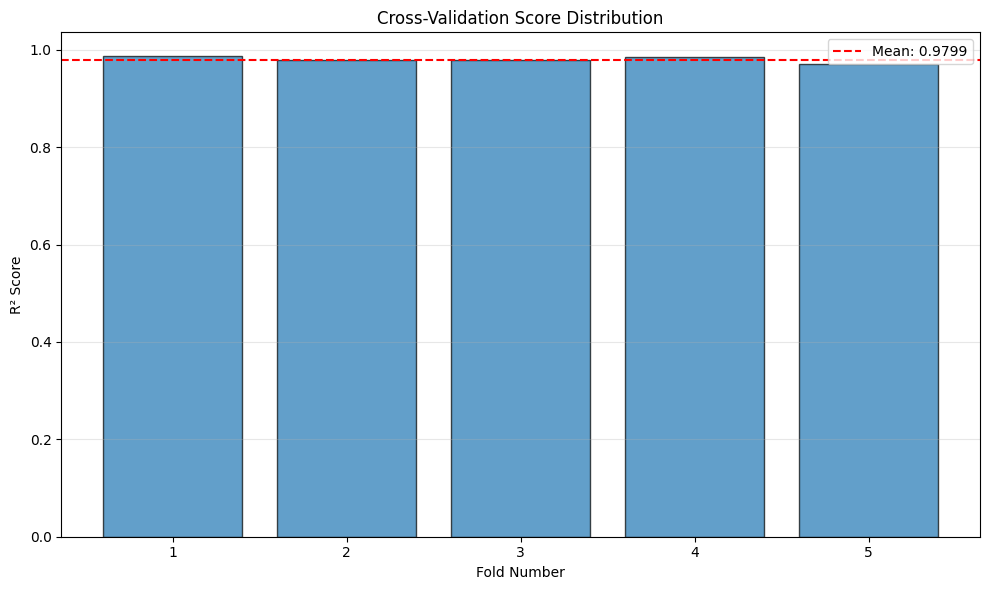


Example 2 Complete! ✓
اكتمل المثال 2! ✓


In [16]:
# Visualize score distribution
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(all_scores) + 1), all_scores, alpha=0.7, edgecolor='black')
plt.axhline(np.mean(all_scores), color='r', linestyle='--', 
           label=f'Mean: {np.mean(all_scores):.4f}')
plt.xlabel('Fold Number')
plt.ylabel('R² Score')
plt.title('Cross-Validation Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('cv_score_distribution.png', dpi=300, bbox_inches='tight')
print("\n✓ Plot saved as 'cv_score_distribution.png'")
plt.show()

print("\n" + "=" * 60)
print("Example 2 Complete! ✓")
print("اكتمل المثال 2! ✓")
print("=" * 60)